In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/sandil/Work/envBase/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
outlets_df = pd.read_csv("./dataset/outlets_data.csv")
sales_df = pd.read_csv("./dataset/sales_data.csv")
week_df = pd.read_csv("./dataset/week_data.csv")
product_df = pd.read_csv("./dataset/product_data.csv")

week_df["Week"] = week_df["Week"].apply(lambda x: int(x.split(" ")[1]))
week_df["Month"] = week_df["End Date"].apply(lambda x: x.split("/")[0])
sales_df = sales_df.rename(columns={"week": "Week"})

sales_level_combined_df = pd.merge(sales_df, week_df, on="Week")
sales_level_combined_df = pd.merge(sales_level_combined_df, product_df, on="pid")

sales_level_combined_df["sales_volume"] = sales_level_combined_df.apply(
    lambda x: x["no_units"] * x["volume"], axis=1
)
sales_level_combined_df["sales_revenue"] = sales_level_combined_df.apply(
    lambda x: x["no_units"] * x["price"], axis=1
)
sales_level_combined_df.head()


,Outlet_ID,Week,pid,product_name_x,no_units,Start Date,End Date,Month,volume,product_name_y,price,sales_volume,sales_revenue
0,ID7203,1,IP1,Vanilla Mini Cone,874.0,1/2/2023,1/8/2023,1,0.2,Vanilla Mini Cone,100,174.8,87400.0
1,ID1878,1,IP1,Vanilla Mini Cone,918.0,1/2/2023,1/8/2023,1,0.2,Vanilla Mini Cone,100,183.6,91800.0
2,ID1740,1,IP1,Vanilla Mini Cone,188.0,1/2/2023,1/8/2023,1,0.2,Vanilla Mini Cone,100,37.6,18800.0
3,ID4366,1,IP1,Vanilla Mini Cone,117.0,1/2/2023,1/8/2023,1,0.2,Vanilla Mini Cone,100,23.4,11700.0
4,ID4722,1,IP1,Vanilla Mini Cone,327.0,1/2/2023,1/8/2023,1,0.2,Vanilla Mini Cone,100,65.4,32700.0


In [19]:
outlet_stats_df = outlets_df.copy()

# total revenue
revenue_totals = (
    sales_level_combined_df.groupby("Outlet_ID")["sales_revenue"]
    .sum()
    .reset_index(name="revenue_totals")
)
outlet_stats_df = pd.merge(outlet_stats_df, revenue_totals, on="Outlet_ID", how="left")

# total volume
volume_totals = (
    sales_level_combined_df.groupby("Outlet_ID")["sales_volume"]
    .sum()
    .reset_index(name="volume_totals")
)
outlet_stats_df = pd.merge(outlet_stats_df, volume_totals, on="Outlet_ID", how="left")

# total units
units_totals = (
    sales_level_combined_df.groupby("Outlet_ID")["no_units"]
    .sum()
    .reset_index(name="units_totals")
)
outlet_stats_df = pd.merge(outlet_stats_df, units_totals, on="Outlet_ID", how="left")

# revenue by product
for pid in product_df["pid"].unique():
    pid_df = sales_level_combined_df[sales_level_combined_df["pid"] == pid]
    pid_df = (
        pid_df.groupby("Outlet_ID")["sales_revenue"]
        .sum()
        .reset_index(name="revenue_" + str(pid))
    )
    outlet_stats_df = pd.merge(outlet_stats_df, pid_df, on="Outlet_ID", how="left")

# volume by product
for pid in product_df["pid"].unique():
    pid_df = sales_level_combined_df[sales_level_combined_df["pid"] == pid]
    pid_df = (
        pid_df.groupby("Outlet_ID")["sales_volume"]
        .sum()
        .reset_index(name="volume_" + str(pid))
    )
    outlet_stats_df = pd.merge(outlet_stats_df, pid_df, on="Outlet_ID", how="left")

# units by product
for pid in product_df["pid"].unique():
    pid_df = sales_level_combined_df[sales_level_combined_df["pid"] == pid]
    pid_df = (
        pid_df.groupby("Outlet_ID")["no_units"]
        .sum()
        .reset_index(name="units_" + str(pid))
    )
    outlet_stats_df = pd.merge(outlet_stats_df, pid_df, on="Outlet_ID", how="left")

# revenue by month
for month in week_df["Month"].unique():
    month_df = sales_level_combined_df[sales_level_combined_df["Month"] == month]
    month_df = (
        month_df.groupby("Outlet_ID")["sales_revenue"]
        .sum()
        .reset_index(name="revenue_month" + str(month))
    )
    outlet_stats_df = pd.merge(outlet_stats_df, month_df, on="Outlet_ID", how="left")

# volume by month
for month in week_df["Month"].unique():
    month_df = sales_level_combined_df[sales_level_combined_df["Month"] == month]
    month_df = (
        month_df.groupby("Outlet_ID")["sales_volume"]
        .sum()
        .reset_index(name="volume_month" + str(month))
    )
    outlet_stats_df = pd.merge(outlet_stats_df, month_df, on="Outlet_ID", how="left")

# volume in week 7
week7_df = sales_level_combined_df[sales_level_combined_df["Week"] == 7]
week7_df = (
    week7_df.groupby("Outlet_ID")["sales_volume"]
    .sum()
    .reset_index(name="volume_week7")
)
outlet_stats_df = pd.merge(outlet_stats_df, week7_df, on="Outlet_ID", how="left")

# median weekly sales volume per outlet
# TODO

# list nan counts
print(outlet_stats_df.isna().sum())

# fill nan with 0
outlet_stats_df = outlet_stats_df.fillna(0)

print(outlet_stats_df.columns)
outlet_stats_df.head()


Index(['Outlet_ID', 'area(sqft)', 'revenue_totals', 'volume_totals',
       'units_totals', 'revenue_IP1', 'revenue_IP2', 'revenue_IP3',
       'revenue_IP4', 'revenue_IP5', 'revenue_BP1', 'revenue_BP2',
       'revenue_BP3', 'revenue_BP4', 'revenue_BP5', 'volume_IP1', 'volume_IP2',
       'volume_IP3', 'volume_IP4', 'volume_IP5', 'volume_BP1', 'volume_BP2',
       'volume_BP3', 'volume_BP4', 'volume_BP5', 'units_IP1', 'units_IP2',
       'units_IP3', 'units_IP4', 'units_IP5', 'units_BP1', 'units_BP2',
       'units_BP3', 'units_BP4', 'units_BP5', 'revenue_month1',
       'revenue_month2', 'revenue_month3', 'volume_month1', 'volume_month2',
       'volume_month3', 'volume_week7'],
      dtype='object')


,Outlet_ID,area(sqft),revenue_totals,volume_totals,units_totals,revenue_IP1,revenue_IP2,revenue_IP3,revenue_IP4,revenue_IP5,...,units_BP3,units_BP4,units_BP5,revenue_month1,revenue_month2,revenue_month3,volume_month1,volume_month2,volume_month3,volume_week7
0,ID7203,5660,3492920.0,6949.2,34746.0,636100.0,656550.0,1003970.0,552000.0,644300.0,...,NaN,NaN,NaN,1133290.0,1220930.0,1138700.0,2235.8,2431.8,2281.6,598.4
1,ID1878,4138,3606340.0,7208.0,36040.0,786000.0,595980.0,754160.0,795400.0,674800.0,...,NaN,NaN,NaN,1130700.0,1280840.0,1194800.0,2235.6,2582.0,2390.4,576.6
2,ID1740,5546,3755910.0,7517.4,37587.0,762500.0,730440.0,862070.0,719200.0,681700.0,...,NaN,NaN,NaN,1363440.0,1195120.0,1197350.0,2742.4,2392.4,2382.6,427.6
3,ID4366,5134,4060130.0,8060.8,40304.0,653000.0,563310.0,1015520.0,875900.0,952400.0,...,NaN,NaN,NaN,1448440.0,1100530.0,1511160.0,2872.2,2197.6,2991.0,636.2
4,ID8358,4100,3918700.0,7875.6,39378.0,705700.0,860580.0,841720.0,624100.0,886600.0,...,NaN,NaN,NaN,1503530.0,1112470.0,1302700.0,3012.2,2267.8,2595.6,632.8


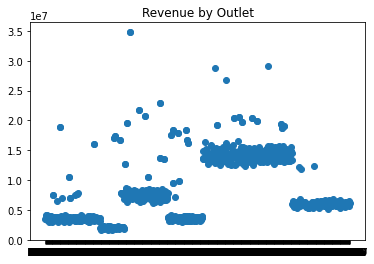

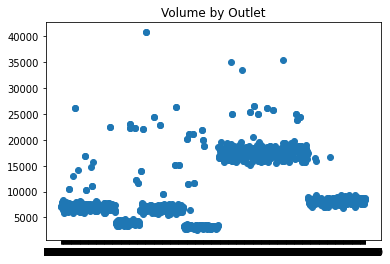

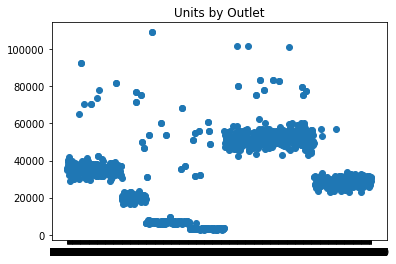

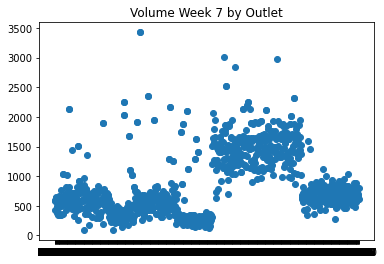

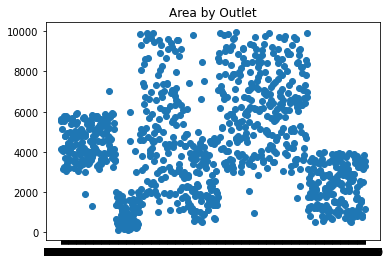

In [43]:
# revenue by outlet
plt.scatter(outlet_stats_df["Outlet_ID"], outlet_stats_df["revenue_totals"])
plt.title("Revenue by Outlet")
plt.show()

# volume by outlet
plt.scatter(outlet_stats_df["Outlet_ID"], outlet_stats_df["volume_totals"])
plt.title("Volume by Outlet")
plt.show()

# units by outlet
plt.scatter(outlet_stats_df["Outlet_ID"], outlet_stats_df["units_totals"])
plt.title("Units by Outlet")
plt.show()

# volume week 7 by outlet
plt.scatter(outlet_stats_df["Outlet_ID"], outlet_stats_df["volume_week7"])
plt.title("Volume Week 7 by Outlet")
plt.show()

# area by outlet
plt.scatter(outlet_stats_df["Outlet_ID"], outlet_stats_df["area(sqft)"])
plt.title("Area by Outlet")
plt.show()

In [163]:
# Autoencoder

class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_sizes, **kwargs):
        super().__init__()
        self.encoder_layers = nn.ModuleList()
        self.decoder_layers = nn.ModuleList()

        # encoder
        for i in range(len(hidden_sizes)):
            if i == 0:
                self.encoder_layers.append(nn.Linear(input_size, hidden_sizes[i]))
            else:
                self.encoder_layers.append(
                    nn.Linear(hidden_sizes[i - 1], hidden_sizes[i])
                )
            self.encoder_layers.append(nn.ReLU())

        # decoder
        for i in range(len(hidden_sizes)):
            if i == len(hidden_sizes) - 1:
                self.decoder_layers.append(
                    nn.Linear(hidden_sizes[0], input_size)
                )
            else:
                self.decoder_layers.append(
                    nn.Linear(hidden_sizes[-i-1], hidden_sizes[-i - 2])
                )
            self.decoder_layers.append(nn.ReLU())

    def forward(self, features):
        for layer in self.encoder_layers:
            features = layer(features)
        for layer in self.decoder_layers:
            features = layer(features)
        return features
    
    def encode(self, features):
        for layer in self.encoder_layers:
            features = layer(features)
        return features

In [164]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

input_df = outlet_stats_df.copy()
for col in input_df.columns:
    if col != "Outlet_ID":
        # input_df[col] = StandardScaler().fit_transform(input_df[col].values.reshape(-1, 1))
        input_df[col] = MinMaxScaler().fit_transform(input_df[col].values.reshape(-1, 1))

train_df, validation_df = train_test_split(input_df, test_size=0.2, random_state=1)
train_df = train_df.drop(columns=["Outlet_ID"])
validation_df = validation_df.drop(columns=["Outlet_ID"])

print(train_df.shape)

input_df.to_csv("input_df1.csv", index=False)

(790, 41)


In [165]:
train_df.head()

,area(sqft),revenue_totals,volume_totals,units_totals,revenue_IP1,revenue_IP2,revenue_IP3,revenue_IP4,revenue_IP5,revenue_BP1,...,units_BP3,units_BP4,units_BP5,revenue_month1,revenue_month2,revenue_month3,volume_month1,volume_month2,volume_month3,volume_week7
47,0.588379,0.054129,0.112440,0.298939,0.420242,0.300699,0.226541,0.373344,0.483610,0.000000,...,0.000000,0.000000,0.000000,0.079089,0.048528,0.053350,0.155580,0.097155,0.108237,0.122494
577,0.344357,0.377066,0.388700,0.461175,0.533717,0.171419,0.513081,0.365888,0.668197,0.356747,...,0.313746,0.427538,0.432087,0.364465,0.360521,0.418812,0.403665,0.355868,0.423990,0.410395
791,0.166684,0.133459,0.156068,0.268348,0.323711,0.302559,0.375044,0.209997,0.259437,0.142791,...,0.107240,0.127165,0.108312,0.134944,0.132851,0.149165,0.154177,0.150402,0.184785,0.154123
19,0.489773,0.065850,0.131340,0.332777,0.470904,0.323226,0.387452,0.443245,0.354863,0.000000,...,0.000000,0.000000,0.000000,0.078639,0.085296,0.050585,0.153468,0.160426,0.100149,0.201596
550,0.613412,0.377601,0.398663,0.488960,0.658432,0.417459,0.345542,0.460708,0.537290,0.449630,...,0.335572,0.375356,0.294517,0.418383,0.391849,0.334130,0.440771,0.408788,0.361403,0.538051


........................................
Train loss: 0.0284
Validation loss: 0.0286


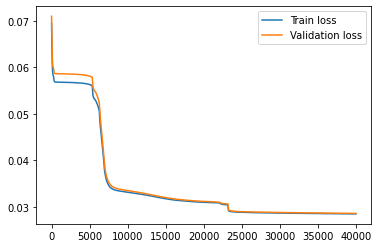

In [188]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hidden_sizes = [17, 7, 3]
criterion = nn.MSELoss()
epochs = 40000

model = Autoencoder(
    input_size=train_df.shape[1],
    hidden_sizes=hidden_sizes
).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# print(model)
train_losses = []
validation_losses = []

train_inputs = torch.from_numpy(train_df.values).float().to(device)
val_inputs = torch.from_numpy(validation_df.values).float().to(device)
for epoch in range(epochs):

    # train
    optimizer.zero_grad()
    outputs = model(train_inputs)
    loss = criterion(outputs, train_inputs)
    loss.backward()
    optimizer.step()
    # train_loss = loss.item() / len(train_df)
    train_loss = loss.item()
    train_losses.append(train_loss)

    # validation
    with torch.no_grad():
        outputs = model(val_inputs)
        loss = criterion(outputs, val_inputs)
        # validation_loss = loss.item() / len(validation_df)
        validation_loss = loss.item()
        validation_losses.append(validation_loss)

    if epoch % (epochs // 40) == 0:
        print(".", end="")

print("\nTrain loss: {:.4f}".format(train_loss))
print("Validation loss: {:.4f}".format(validation_loss))

plt.plot(train_losses, label="Train loss")
plt.plot(validation_losses, label="Validation loss")
plt.legend()
plt.show()


In [189]:
print(train_loss, validation_loss, model)

0.028442487120628357 0.02855037897825241 Autoencoder(
  (encoder_layers): ModuleList(
    (0): Linear(in_features=41, out_features=17, bias=True)
    (1): ReLU()
    (2): Linear(in_features=17, out_features=7, bias=True)
    (3): ReLU()
    (4): Linear(in_features=7, out_features=3, bias=True)
    (5): ReLU()
  )
  (decoder_layers): ModuleList(
    (0): Linear(in_features=3, out_features=7, bias=True)
    (1): ReLU()
    (2): Linear(in_features=7, out_features=17, bias=True)
    (3): ReLU()
    (4): Linear(in_features=17, out_features=41, bias=True)
    (5): ReLU()
  )
)


In [198]:
MODEL_FILE_PATH = "autoencoder-note.pt"
torch.save(model, MODEL_FILE_PATH)

loaded_model = torch.load(MODEL_FILE_PATH)
print(loaded_model)

Autoencoder(
  (encoder_layers): ModuleList(
    (0): Linear(in_features=41, out_features=17, bias=True)
    (1): ReLU()
    (2): Linear(in_features=17, out_features=7, bias=True)
    (3): ReLU()
    (4): Linear(in_features=7, out_features=3, bias=True)
    (5): ReLU()
  )
  (decoder_layers): ModuleList(
    (0): Linear(in_features=3, out_features=7, bias=True)
    (1): ReLU()
    (2): Linear(in_features=7, out_features=17, bias=True)
    (3): ReLU()
    (4): Linear(in_features=17, out_features=41, bias=True)
    (5): ReLU()
  )
)


In [199]:

for i in range(5):
    with torch.no_grad():
        outputs = loaded_model(val_inputs[i].reshape(1, -1))

    print(val_inputs[i])
    print(outputs, "\n")

tensor([0.4721, 0.3762, 0.3817, 0.4425, 0.5367, 0.3503, 0.4797, 0.3809, 0.3764,
        0.4037, 0.4084, 0.4084, 0.4168, 0.2806, 0.5367, 0.3503, 0.4797, 0.3809,
        0.3764, 0.4037, 0.4084, 0.4084, 0.4168, 0.2806, 0.5367, 0.3503, 0.4797,
        0.3809, 0.3764, 0.4037, 0.4084, 0.4084, 0.4168, 0.2806, 0.3849, 0.3897,
        0.3652, 0.4080, 0.3700, 0.3836, 0.3271], device='cuda:0')
tensor([[0.5965, 0.3518, 0.0000, 0.4240, 0.4751, 0.4115, 0.4164, 0.4166, 0.4447,
         0.0000, 0.0000, 0.0000, 0.0000, 0.3145, 0.0000, 0.4284, 0.4056, 0.4068,
         0.4516, 0.3884, 0.3437, 0.3464, 0.0000, 0.3181, 0.4556, 0.4244, 0.4164,
         0.3889, 0.4472, 0.3699, 0.0000, 0.0000, 0.0000, 0.2990, 0.3656, 0.0000,
         0.3697, 0.3996, 0.0000, 0.0000, 0.3779]], device='cuda:0') 

tensor([0.1043, 0.0158, 0.0454, 0.1788, 0.2565, 0.2346, 0.2108, 0.2139, 0.2109,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2565, 0.2346, 0.2108, 0.2139,
        0.2109, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.25

In [200]:
for i in range(5):
    with torch.no_grad():
        encoded = loaded_model.encode(val_inputs[i].reshape(1, -1))

    print(encoded)

tensor([[0.0000, 0.0000, 1.2977]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.5376]], device='cuda:0')
tensor([[0.0000, 0.0000, 0.6729]], device='cuda:0')
tensor([[0., 0., 0.]], device='cuda:0')
tensor([[0.0000, 0.0098, 1.3171]], device='cuda:0')


In [201]:
loaded_model = torch.load(MODEL_FILE_PATH)
print(loaded_model)

input_df = pd.read_csv("input_df2.csv")
all_inputs = torch.from_numpy(input_df.drop(columns=["Outlet_ID"]).values).float().to(device)
with torch.no_grad():
    encoded = loaded_model.encode(all_inputs)

# write to csv
encoded_df = pd.DataFrame(encoded.cpu().numpy())
encoded_df["Outlet_ID"] = input_df["Outlet_ID"]
encoded_df = encoded_df[["Outlet_ID"] + list(range(encoded_df.shape[1] - 1))]
encoded_df.to_csv("encoded_outlets.csv", index=False)

Autoencoder(
  (encoder_layers): ModuleList(
    (0): Linear(in_features=41, out_features=17, bias=True)
    (1): ReLU()
    (2): Linear(in_features=17, out_features=7, bias=True)
    (3): ReLU()
    (4): Linear(in_features=7, out_features=3, bias=True)
    (5): ReLU()
  )
  (decoder_layers): ModuleList(
    (0): Linear(in_features=3, out_features=7, bias=True)
    (1): ReLU()
    (2): Linear(in_features=7, out_features=17, bias=True)
    (3): ReLU()
    (4): Linear(in_features=17, out_features=41, bias=True)
    (5): ReLU()
  )
)


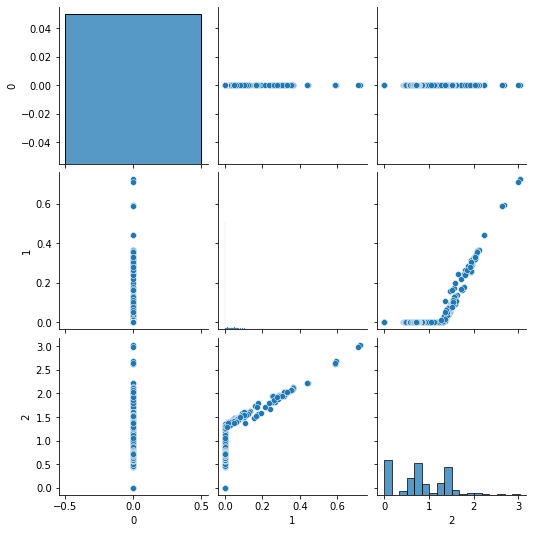

In [202]:
# sns pairplot
import seaborn as sns

sns.pairplot(encoded_df)

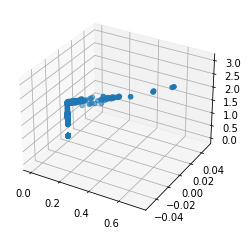

In [203]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(encoded_df[1], encoded_df[0], encoded_df[2])
plt.show()

# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.scatter(encoded_df[1], encoded_df[3], encoded_df[0])
# plt.show()

# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.scatter(encoded_df[2], encoded_df[0], encoded_df[3])
# plt.show()

# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.scatter(encoded_df[1], encoded_df[2], encoded_df[3])
# plt.show()

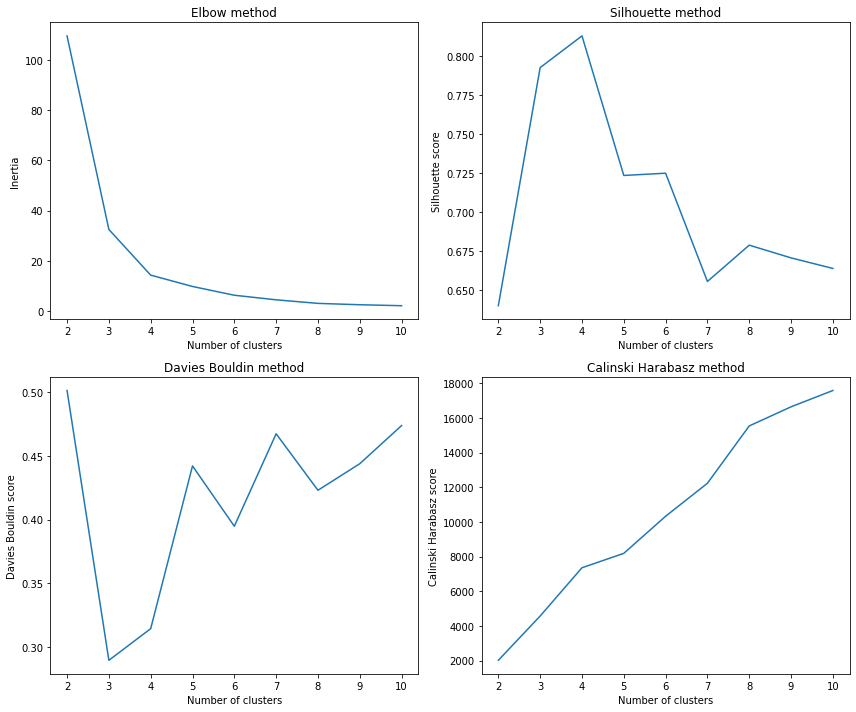

In [204]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans


inertia = []
silhouette_scores = []
db_scores = []
ch_scores = []

temp_df = encoded_df.drop(columns=["Outlet_ID"])
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=0, n_init=30).fit(temp_df)
    labels = kmeans.labels_
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(temp_df, labels))
    db_scores.append(davies_bouldin_score(temp_df, labels))
    ch_scores.append(calinski_harabasz_score(temp_df, labels))

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Elbow method plot
axs[0, 0].plot(range(2, 11), inertia)
axs[0, 0].set_title("Elbow method")
axs[0, 0].set_xlabel("Number of clusters")
axs[0, 0].set_ylabel("Inertia")

# Silhouette method plot
axs[0, 1].plot(range(2, 11), silhouette_scores)
axs[0, 1].set_title("Silhouette method")
axs[0, 1].set_xlabel("Number of clusters")
axs[0, 1].set_ylabel("Silhouette score")

# Davies Bouldin method plot
axs[1, 0].plot(range(2, 11), db_scores)
axs[1, 0].set_title("Davies Bouldin method")
axs[1, 0].set_xlabel("Number of clusters")
axs[1, 0].set_ylabel("Davies Bouldin score")

# Calinski Harabasz method plot
axs[1, 1].plot(range(2, 11), ch_scores)
axs[1, 1].set_title("Calinski Harabasz method")
axs[1, 1].set_xlabel("Number of clusters")
axs[1, 1].set_ylabel("Calinski Harabasz score")

plt.tight_layout()
plt.show()

In [206]:
encoded_df.describe()

,0,1,2
count,988.0,988.000000,988.000000
mean,0.0,0.026196,0.807078
std,0.0,0.074276,0.576593
min,0.0,0.000000,0.000000
25%,0.0,0.000000,0.495633
50%,0.0,0.000000,0.774561
75%,0.0,0.016347,1.347230
max,0.0,0.723120,3.030007


In [207]:
kmeans = KMeans(n_clusters=4, random_state=0, n_init=30).fit(temp_df)
labels = kmeans.labels_
print(kmeans.inertia_)
print("silhoutte", silhouette_score(temp_df, labels))
print("dbi", davies_bouldin_score(temp_df, labels))
print("chs", calinski_harabasz_score(temp_df, labels))

14.242897987365723
silhoutte 0.813117
dbi 0.3146260970220869
chs 7354.100467390391
